In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, norm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import norm
from pypalettes import load_cmap
import geopandas as gpd
import contextily as ctx
from matplotlib.patches import FancyArrowPatch
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

In [12]:
# Function to interpolate the colormap with cubic interpolation
def interpolate_cmap(cmap, num_interp_points):
    new_colors = cmap(np.linspace(0, 1,cmap.N))  
    new_cmap = LinearSegmentedColormap.from_list('my_interpolated_cmap', new_colors, N=num_interp_points)
    return new_cmap

In [13]:
basin = gpd.read_file('3Sbasin.shp')
 
basin = basin.to_crs(epsg=3857)
y_min, y_max = basin.total_bounds[1], basin.total_bounds[3]
x_max=basin.total_bounds[2]
x_min=basin.total_bounds[0]
print(f"Y min: {x_min}")
print(f"Y max: {x_max}")

Y min: 11793225.96486322
Y max: 12109451.992040318


In [14]:
# Cap values for each indicator (the ones used to normalize the values of each objective between 0 and 1 during the optimization)
maxtotalpro = 8.627501095537942e+06 #hp production
maxfirm = 3.207057309002500e+04 #firm hp
maxsed = 30 #sediment loads

In [15]:
# Reading optimization results for sluicing
filename = 'optimization_objectives_sluicing.txt'
data = np.loadtxt(filename)
all_data = data

# Check whether all the solutions are pareto optimal solutions
is_pareto_efficient = np.ones(all_data.shape[0], dtype=bool)

for i, current_point in enumerate(all_data):
    for j, other_point in enumerate(all_data):
        # If we have more solutions with the same values we keep just one solution
        if (
            all(other_point < current_point) and 
            not np.array_equal(other_point, current_point)
        ):
            is_pareto_efficient[i] = False
            break


fnew = all_data[is_pareto_efficient]


fnew_unique = np.unique(fnew, axis=0)

# For the following plot, we locate sediment objective on the first column, hydro production on the second one, and firm hp on the third
a = fnew_unique[:, 0].copy()
b = fnew_unique[:, 1].copy()
fnew_unique[:, 0] = fnew_unique[:, 2]
fnew_unique[:, 1] = a
fnew_unique[:, 2] = b

fnew_unique_sluicing = fnew_unique
fnew_unique_sluicing[:, 0] = (1 - fnew_unique_sluicing[:, 0]) * maxsed;
fnew_unique_sluicing[:, 1] = (1 - fnew_unique_sluicing[:, 1]) * maxtotalpro*10**(-6) * 24 / 15
fnew_unique_sluicing[:, 2] = (1 - fnew_unique_sluicing[:, 2]) * maxfirm*24*10**(-3)
print(f"Pareto-efficient points:\n{fnew_unique}")

Pareto-efficient points:
[[  8.48545064  10.69293238  85.7256215 ]
 [  8.55969643  10.68624704  76.24217362]
 [  8.53298208  10.68606248  77.36689363]
 [  8.48973385  10.68232305  80.54368389]
 [  8.55721744  10.67744788  96.0633348 ]
 [  8.55985855  10.67634219  75.64455603]
 [  8.66051052  10.67501812  50.90036103]
 [  8.64623999  10.66828114  89.18124091]
 [  8.64651443  10.6552143   80.56954367]
 [  8.78560146  10.63472327  75.67177136]
 [  8.63727639  10.63013672  94.87493448]
 [  8.9169812   10.61953886  39.09196907]
 [  8.67188797  10.61681971  76.28611589]
 [  8.9194842   10.61633963  39.85053084]
 [  8.77844246  10.61248801 146.98143153]
 [  8.78102901  10.61141142 143.19190041]
 [  8.79214637  10.60637551 116.08325636]
 [  8.91787326  10.59727585 105.78162954]
 [  8.92665303  10.59421805 106.95777748]
 [  8.38025489  10.57171847 173.76828003]
 [  8.91717392  10.55707548 153.75002973]
 [  8.75277934  10.55688474 203.08594817]
 [  9.0452796   10.55470262  58.40368905]
 [  8.917

In [16]:
# Indices of the fnew_unique_flush matrix used for plotting the Pareto frontier
index_firm_maxsluicing = np.array([223], dtype=np.uint8)
index_sediment_maxsluicing = np.array([217], dtype=np.uint16)
index_hydro_maxsluicing = np.array([0], dtype=np.uint16)
indices_other = np.array([71, 225,   5,   8, 142, 224, 223,  15,  72,  23,  35,  68,  58,
                    112,  24,  17,   1,  47,  91,   6,  27,  28,  10,  16,  69,   3,
                    92,  26,  41, 113,   7,  56,   2,  12,  50,   9,   0,  19,  29,
                    87,  22,  11,  84,  25,  38,  14,  54,  18,  21,  20, 212, 114,
                    30,   4,  49,  13], dtype=np.uint16) 
indices_plot= np.array([  48,  75, 216, 141,  66,  86, 220,  51, 131, 122,  90, 130, 136,
                    165,  79, 150, 210, 145, 137, 215, 160, 221, 222,  82, 177, 171,
                    115, 102, 187,  60, 180,  96, 120,  46, 146, 173,  45, 121, 197,
                    98, 185, 167, 107, 199, 211, 191,  32, 203,  99, 201,  53, 103,
                    80, 156, 182, 207, 175, 119, 155, 174, 157, 169, 208, 172, 179,
                    110, 198,  33, 140, 213,  74, 144,  44, 162, 154,  37, 193, 159,
                    186,  36, 163, 170, 195, 108, 139, 176, 183, 153, 161, 188,  70,
                    97, 149, 194, 205,  76,  64,  81,  31, 111,  43, 100,  89, 202,
                    57, 166, 134,  94,  34, 135, 133,  39, 189, 178,  59, 152, 217,
                    129,  65, 206,  61, 118, 101, 214, 128, 104, 127,  67, 143, 168,
                    209,  78, 192, 125, 184, 106,  83,  93,  42, 196, 158, 138,  55,
                    62, 147,  40, 116, 164,  88, 190, 105,  95, 148, 124,  77,  85,
                    204, 181, 109,  73,  52, 117, 151, 126, 123,  63, 200, 132, 218,
                    219],
                    dtype=np.uint16)

In [17]:
# Historical values of the three objectives
# Obtained simulating VICRes-CASCADE from 2008 to 2022 with the original water rule curve
historicalpro = 8.98376805
historicalfirm = 157.25352679
historicalsedload = 8.39035134

/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_9120/1408622583.py:122: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(row.geometry.x, row.geometry.y,
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_9120/1408622583.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(row.geometry.x, row.geometry.y,
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_9120/1408622583.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter3 = ax.scatter(fnew_unique_sluicing[index_sediment_maxsluicing, 1], fnew_unique_sluicing[index_sediment_maxsluicing, 2], s

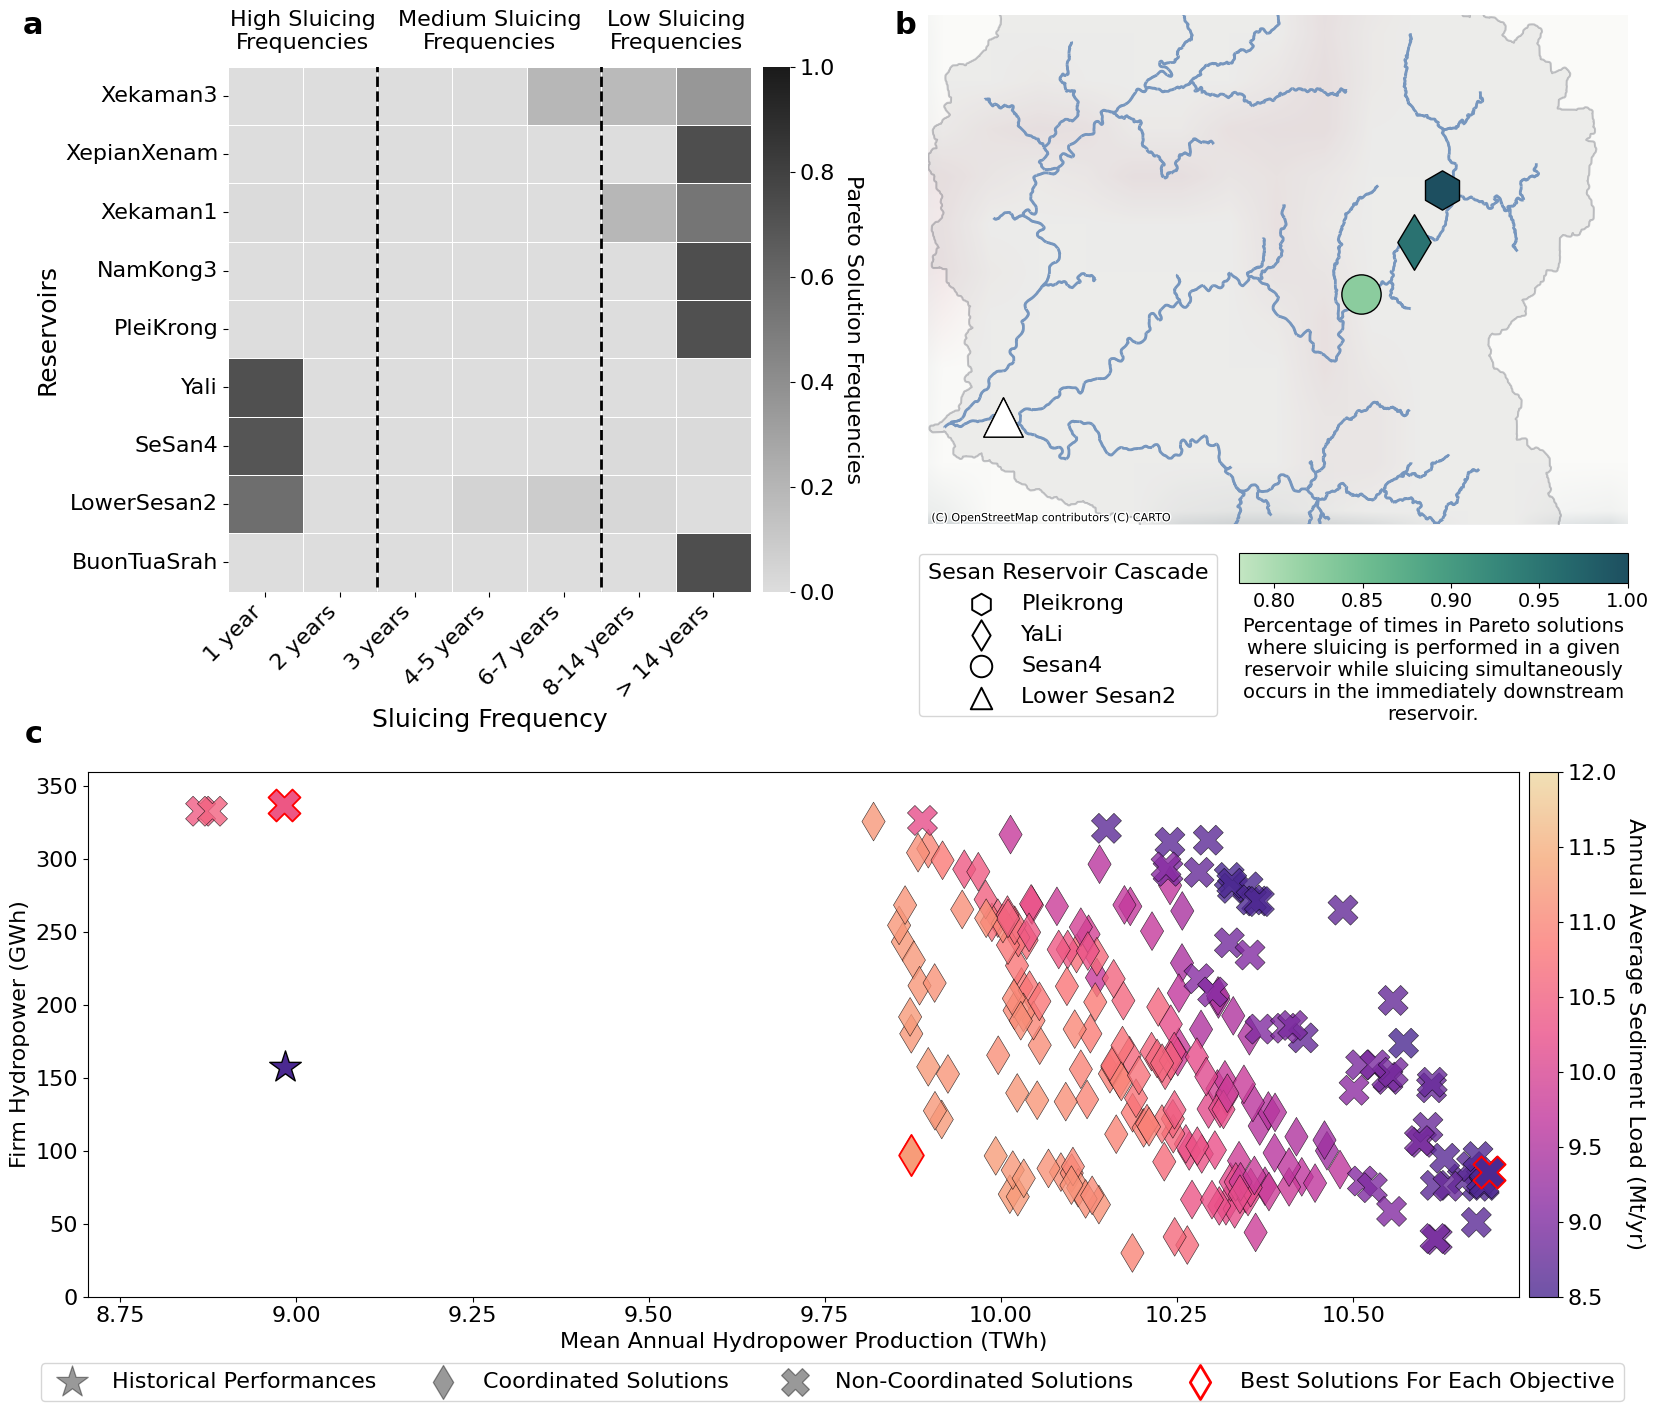

In [19]:
def plot1(ax):
    cmap = load_cmap("borg")
    cmap=cmap.reversed()
    cmap = interpolate_cmap(cmap, 1000)
    # Load data from CSV files
    freq = pd.read_csv('frequencies.csv', header=None)
    freq=freq.T
    # Setting columns names
    freq.columns = ['1 year', '2 years' ,'3 years' , '4-5 years', '6-7 years', '8-14 years', '> 14 years']

    # Setting rows names
    values = ['Xekaman3','XepianXenam','Xekaman1','NamKong3','PleiKrong','Yali','SeSan4', 'LowerSesan2', 'BuonTuaSrah']
    freq.index = values
    
    

    
    ax=sns.heatmap(freq, annot=False, cmap=cmap, linewidths=.6,cbar_kws={'shrink': 1, 'aspect': 20, 'pad': 0.02})
    
    cbar = ax.collections[0].colorbar
    cbar.mappable.set_clim(0,1)
    cbar.ax.set_ylabel('Pareto Solution Frequencies', rotation=270, fontsize=16,labelpad=20)
    cbar.ax.tick_params(labelsize=16)
    
    freq_high = 2
    freq_low = 4
    freq_never = 6
    
    xmin, xmax = ax.get_xlim()  
    ymin, ymax = ax.get_ylim()  
    
    ax.axvline(2, -1, 2, color='black', linestyle='--', linewidth=2) 
    ax.axvline(5, -1, 2, color='black', linestyle='--', linewidth=2) 
    
    ax.text(1, -0.3, 'High Sluicing\nFrequencies', ha='center', fontsize=16)
    ax.text(3.5, -0.3, 'Medium Sluicing\nFrequencies', ha='center', fontsize=16)
    
    ax.text(6, -0.3, 'Low Sluicing\nFrequencies', ha='center', fontsize=16)

    ax.set_xticks(range(len(freq.columns)))
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16)
    ax.set_yticks(range(len(freq.index)))
    ax.set_yticklabels(freq.index, fontsize=16,ha='center')
    # Titles
    ax.set_xlabel('Sluicing Frequency', fontsize=18)
    ax.set_ylabel('Reservoirs', fontsize=18)
    
    ax.set_xticks(np.arange(len(freq.columns)) + 0.5)
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16, ha='right')

    ax.set_yticks(np.arange(len(freq.index)) + 0.5)
    ax.set_yticklabels(freq.index, fontsize=16, va='center',ha='right')

def plot2(ax):
    reservoirs = gpd.read_file('reservoir.shp')
    basin = gpd.read_file('3Sbasin.shp')
    rivernetwork = gpd.read_file('rivernetwork.shp')

    # Project everything to Web Mercator (EPSG:3857) for use with contextily
    reservoirs = reservoirs.to_crs(epsg=3857)
    basin = basin.to_crs(epsg=3857)
    rivernetwork = rivernetwork.to_crs(epsg=3857)

    
    selected_reservoirs = ['Pleikrong', 'YaLi', 'Sesan4', 'LowerSesan2']
    selected_lss = ['LowerSesan2']

    # Filter the selected reservoirs and calculate the percentages
    selected_reservoirs_data = reservoirs[reservoirs['name'].isin(selected_reservoirs)]
    lowersesan=reservoirs[reservoirs['name'].isin(selected_lss)]
    labels = selected_reservoirs_data['name'].tolist() 
    # Load data from CSV files
    frequenze_df = pd.read_csv('histogram_frequencies.csv', header=None)
    frequenze = frequenze_df.values.flatten()
    
    frequenze = np.append(frequenze, 0)

    cmap = load_cmap("BluGrn")
    cmap = interpolate_cmap(cmap, 1000)
    # Generate colors based on the values of 'frequencies'
    norm = mcolors.Normalize(vmin=0.77, vmax=max(frequenze))
    colors = cmap(norm(frequenze))

    # Define the categories on the x-axis
    categorie = ['PleiKrong', 'Yali', 'Sesan4']
    scatter_1 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='h',edgecolors='black',linewidth=1.4, label='Pleikrong')
    
    scatter_2 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='d',edgecolors='black',linewidth=1.4, label='YaLi')
    
    scatter_3 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='o',edgecolors='black',linewidth=1.4, label='Sesan4')
    
    scatter_4 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='^',edgecolors='black',linewidth=1.4, label='Lower Sesan2')
    ax.axis('off')
    mark=['h','d','o','^']
    cmap1 = load_cmap("Classic_Gray_5")
    cmap1 = interpolate_cmap(cmap1, 1000)
    basin.plot(ax=ax, facecolor=cmap1(0.99),alpha=0.3, edgecolor=cmap1(0.5),linewidth=1.5)
    
    prova=['Pk','YL','S4','Lss2']
    #srepok.plot(ax=ax, facecolor="none", edgecolor="green", label='Srepok Sub-basin')
    #sesan.plot(ax=ax, facecolor="none", edgecolor="orange", label='Sesan Sub-basin')
    #sekong.plot(ax=ax, facecolor="none", edgecolor="purple", label='Sekong Sub-basin')
    cmap2 = load_cmap("Bmsurface")
    rivernetwork.plot(ax=ax, color=cmap2(0.5),linewidth=2,zorder=1)
    
    
    i=0
    
    for idx, row in selected_reservoirs_data.iterrows():
        scatter = ax.scatter(row.geometry.x, row.geometry.y, 
               marker=mark[i], s=800, c=colors[i],cmap=cmap, edgecolor='black')
        #ax.text(row.geometry.x, row.geometry.y, prova[i], fontsize=14, ha='left', va='bottom')
        i=i+1
    scatter = ax.scatter(lowersesan.geometry.x, lowersesan.geometry.y, 
               marker='^', s=800, c='white', edgecolor='black')
    #ax.set_title('Sesan Reservoir Cascade',fontsize=16)
    ax.set_aspect('equal')
    ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.CartoDB.Positron)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.NASAGIBS.BlueMarble)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.USGS.USTopo)
    ax.set_ylim((1481903,1690833))
    ax.set_xlim((11793225,12080451))
    
    ax.axis('off')
    
    

    # colormap configuration
    norm = plt.Normalize(vmin=0.78, vmax=1)
    
    cbaxes = fig.add_axes([0.722, 1.006, 0.278, 0.02]) 
    
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes("bottom", size="5%", pad=0.5)  # posizioniamo sotto e aumentiamo il pad per spazio testo

    # colormap
    cb = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbaxes, orientation='horizontal')
    cb.set_label('Percentage of times in Pareto solutions\nwhere sluicing is performed in a given\nreservoir while sluicing simultaneously\noccurs in the immediately downstream\nreservoir.', fontsize=14)
    cb.ax.tick_params(labelsize=14)
    #cb.ax.set_position([1, 0.6, 0.2, 0.1])
    
    text_x = (ax.get_position().x0 + ax.get_position().x1) / 2
    text_y = cbaxes.get_position().y0 - 0.05  # regoliamo la posizione y del testo
    #fig.text(text_x, text_y, 'Il colore indica la frequenza di sluicing coordinato.', ha='center', fontsize=12)

    legend = ax.legend(fontsize=16,loc='lower center', bbox_to_anchor=(0.2, -0.4))
    legend.set_title('Sesan Reservoir Cascade',prop={'size': 16})


   

def plot3(ax):
    
    cmap = load_cmap("ag_Sunset")
    cmap = interpolate_cmap(cmap, 1000)
    #cmap=cmap.reversed()
    
    

    color_values = fnew_unique_sluicing[:, 0]
    color_min = 8.5
    color_max = 12
    color_values = np.clip(color_values, color_min, color_max)
    norm = mcolors.Normalize(vmin=8.5, vmax=12)
    specific_value4 = historicalsedload
    specific_value5 = color_values[index_sediment_maxsluicing]
    specific_value6 = color_values[index_hydro_maxsluicing]
    specific_value7 = color_values[index_firm_maxsluicing]
    

    # Normalize the specific value based on the colormap range
    norm = mcolors.Normalize(vmin=color_min, vmax=color_max)
    normalized_value4 = norm(specific_value4)
    normalized_value5 = norm(specific_value5)
    normalized_value6 = norm(specific_value6)
    normalized_value7 = norm(specific_value7)
    

    fixed_color4 = cmap(normalized_value4)
    fixed_color5 = cmap(normalized_value5)
    fixed_color6 = cmap(normalized_value6)
    fixed_color7 = cmap(normalized_value7)
    

    c = color_values

    scatter_1 = ax.scatter(0,
                            0,
                            s=570, c='black', alpha=0.4,
                            marker='*',edgecolors='black',linewidth=0.9, label='Historical Performances')

    scatter_2 = ax.scatter(0,
                                0,
                                s=300, c='black', alpha=0.4,
                                marker='d',edgecolors='black',linewidth=0.9, label='Coordinated Solutions')

    scatter_3 = ax.scatter(0,
                            0,
                            s=400, c='black', alpha=0.4,
                            marker='X',edgecolors='black',linewidth=0.9, label='Non-Coordinated Solutions')

    scatter_4 = ax.scatter(0, 0,
                                    s=300, c='white', alpha=1, marker='d',edgecolors='red',linewidth=2,
                                    label='Best Solutions For Each Objective')
    
    scatter1 = ax.scatter(fnew_unique_sluicing[indices_plot, 1], fnew_unique_sluicing[indices_plot, 2], s=390, c=c[indices_plot],cmap=cmap,norm=norm,marker='d',alpha=0.8, edgecolor='black', linewidth=0.4)
    scatter2 = ax.scatter(fnew_unique_sluicing[indices_other, 1], fnew_unique_sluicing[indices_other, 2], s=470, c=c[indices_other],cmap=cmap,norm=norm, marker='X',alpha=0.8, edgecolor='black', linewidth=0.4)
    
    scatter3 = ax.scatter(fnew_unique_sluicing[index_sediment_maxsluicing, 1], fnew_unique_sluicing[index_sediment_maxsluicing, 2], s=440, facecolor=fixed_color5,cmap=cmap,marker='d', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_sluicing[indice_sediment_maxsluicing, 1], fnew_unique_sluicing[indice_sediment_maxsluicing, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')
    scatter6 = ax.scatter(fnew_unique_sluicing[index_hydro_maxsluicing, 1], fnew_unique_sluicing[index_hydro_maxsluicing, 2], s=530, facecolor=fixed_color6,cmap=cmap, marker='X', edgecolor='red',linewidth=1.5)
    #ax.plot(fnew_unique_sluicing[indice_hydro_maxsluicing, 1], fnew_unique_sluicing[indice_hydro_maxsluicing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')

    scatter7 = ax.scatter(fnew_unique_sluicing[index_firm_maxsluicing, 1], fnew_unique_sluicing[index_firm_maxsluicing, 2], s=530, facecolor=fixed_color7, cmap=cmap, marker='X', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_flush[indice_firm_maxsluicing, 1], fnew_unique_flush[indice_firm_maxsluicing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor=l[indice_firm_maxsluicing], markeredgecolor='red')

    scatter4 = ax.scatter(historicalpro, historicalfirm, s=570, facecolor=fixed_color4,cmap=cmap, marker='*', edgecolor='black')
    #ax.plot(fnew_unique_flush[indicecompromize2flush, 1], fnew_unique_flush[indicecompromize2flush, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor=[0.0588, 0.3608, 0.0314])

    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    
    cb = plt.colorbar(scatter1, cax=cax)
    cb.mappable.set_clim(color_min, color_max)
    cb.set_label('Annual Average Sediment Load (Mt/yr)', fontsize=16, rotation=270, labelpad=20)
    cb.ax.tick_params(labelsize=16)

    ax.set_xlabel('Mean Annual Hydropower Production (TWh)', fontsize=16)
    ax.set_ylabel('Firm Hydropower (GWh)', fontsize=16)
    ax.set_ylim([0, 15000 * 10**(-3) * 24])
    ax.set_xlim([5.44 * 10**6 * 10**(-6) * 24 / 15, 6.71 * 10**6 * 10**(-6) * 24 / 15])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    
    legend = ax.legend(fontsize=16,loc='lower center', bbox_to_anchor=(0.52, -0.22), ncol=4)
    legend.set_title(None)


#fig = plt.figure(figsize=(14, 15))


fig = plt.figure(figsize=(14, 15))

left = 0.0
bottom = 1
width = 0.45
height = 0.35

ax1 = fig.add_axes([left, bottom, width, height])
plt.sca(ax1)  
plot1(ax1)

left = 0.5
bottom = 0.98
width = 0.5
height = 0.47

ax2 = fig.add_axes([left, bottom, width, height])
plt.sca(ax2)  
plot2(ax2)

left = -0.1
bottom = 0.53
width = 1.05
height = 0.35


ax3 = fig.add_axes([left, bottom, width, height])
plt.sca(ax3)  
plot3(ax3)
ax3.text(5.40 * 10**6 * 10**(-6) * 24 / 15, 380, 'c', fontsize=22, ha='right',fontweight='bold')
ax3.text(5.40 * 10**6 * 10**(-6) * 24 / 15, 866, 'a', fontsize=22, ha='right',fontweight='bold')
ax3.text(6.175 * 10**6 * 10**(-6) * 24 / 15, 866, 'b', fontsize=22, ha='right',fontweight='bold')

#plt.tight_layout()
#fig.set_size_inches(7.09, fig.get_size_inches()[1])

fig.savefig('Figure5.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1,dpi=300)
#plt.savefig('Figure5.eps', format='eps', dpi=100)

#width, height = fig.get_size_inches()


#print(f"Larghezza: {width} pollici, Altezza: {height} pollici")


#dpi = fig.dpi

# Mostrare il grafico combinato
plt.show()